In [69]:
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from itertools import combinations
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from skimage import data, feature, exposure
from skimage.feature import blob_dog, blob_log
from PIL import Image
import pillow_heif
import os.path

# im1_path = r'Boaz stars 1.png'
# im2_path = r'Boaz stars 2.png'
im1_path = r'Stars/IMG_3046.HEIC'
im2_path = r'Stars/IMG_3047.HEIC'

## 1. Load the Images

In [80]:
def validate_path(img_path):
    try:
        # Check if image format is .heic
        parsed_path = img_path.split('.')
        if parsed_path[-1] in ['HEIC', 'heic']:
            print('heic')
            heif_file = pillow_heif.read_heif(img_path)
            im = Image.frombytes(
                heif_file.mode,
                heif_file.size,
                heif_file.data,
                "raw",
            )
            new_path = f"{parsed_path[0]}.png"
            if not os.path.isfile(new_path):  # check if image was already saved
                im.save(new_path, format('png'))
            return new_path
        return img_path
    except Exception as e:
        print(e)

In [81]:
def load_image(img_path):
    try:
        valid_path = validate_path(img_path)
        im = cv2.cvtColor(cv2.imread(valid_path), cv2.COLOR_BGR2GRAY)
        im = im.astype(float)
        return im
    except Exception as e:
        print(e)

In [78]:
im1 = load_image(im1_path)
im2 = load_image(im2_path)

heic
True
heic
True


array([[47., 46., 46., ..., 26., 25., 30.],
       [52., 51., 52., ..., 29., 25., 31.],
       [50., 49., 52., ..., 28., 22., 27.],
       ...,
       [28., 28., 27., ..., 27., 40., 43.],
       [30., 26., 25., ..., 25., 34., 38.],
       [27., 24., 26., ..., 19., 34., 39.]])

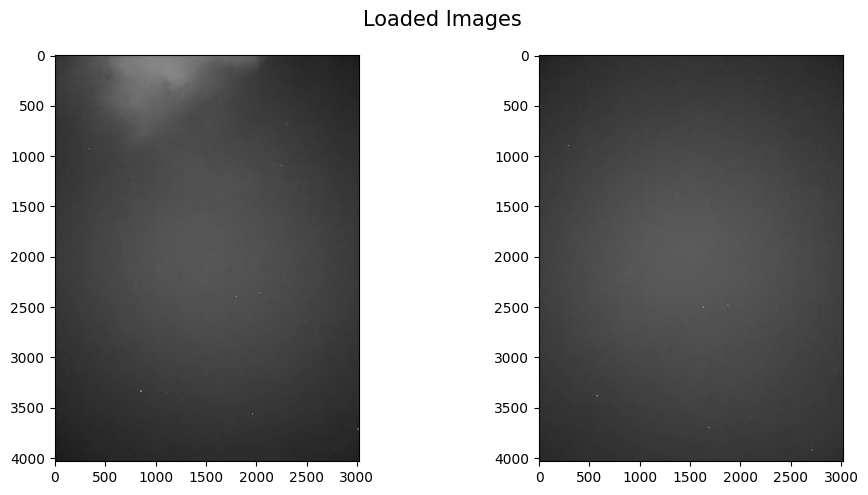

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Loaded Images", size=15)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')
plt.tight_layout()
plt.show()

## 2. Detect Stars in Each Image

In [83]:
def find_stars(img):
    fwhm = 3.0
    sigma = 3.
    mean, median, std = sigma_clipped_stats(img, sigma=sigma)
    thresh = 1. * std
    daofind = DAOStarFinder(fwhm=fwhm, threshold=thresh)
    table = daofind(img - median)

    sigma = gaussian_fwhm_to_sigma * fwhm
    radius = fwhm / (2.0 * sigma)
    table['radius'] = radius

    # calculate the pixel intensity of each star using aperture photometry
    positions = np.transpose((table['xcentroid'], table['ycentroid']))
    # brightness = []
    # for x, y in positions:
    #     x, y = round(x), round(y)
    #     brightness.append(img[y, x])
    # table['brightness'] = brightness
    table['brightness'] = table['peak'] + median

    for col in table.colnames:
        if col not in ('id', 'npix'):
            table[col].info.format = '%.2f'  # for consistent table output
    return table

In [84]:
def print_data(stars):
    print(len(stars))
    stars.pprint()

In [85]:
im1_stars = find_stars(im1)
print_data(im1_stars)

4515
 id  xcentroid ycentroid sharpness roundness1 ... flux  mag  radius brightness
---- --------- --------- --------- ---------- ... ---- ----- ------ ----------
   1   1526.17      1.41      0.27      -0.79 ... 1.96 -0.73   1.18     122.00
   2   2297.34      2.64      0.63       0.69 ... 1.29 -0.28   1.18      65.00
   3   2826.16      3.97      0.46      -0.76 ... 1.16 -0.16   1.18      45.00
   4   2134.43      7.64      0.51       0.73 ... 1.10 -0.11   1.18      66.00
   5   2225.20      7.84      0.58      -0.96 ... 1.10 -0.10   1.18      60.00
   6   2230.27      9.66      0.41       0.97 ... 1.62 -0.52   1.18      55.00
   7   2255.77      8.79      0.57      -0.06 ... 1.44 -0.39   1.18      60.00
   8   2905.30      9.17      0.51      -0.39 ... 1.21 -0.21   1.18      44.00
   9   2854.70     10.99      0.72      -0.19 ... 1.47 -0.42   1.18      47.00
  10   2909.76     10.56      0.47      -0.09 ... 1.08 -0.09   1.18      39.00
 ...       ...       ...       ...        ... .

In [532]:
# im2_stars = find_stars(im2)
# print_data(im2_stars)

In [533]:
def find_stars_blob(img):
    mean, median, std = sigma_clipped_stats(img, sigma=3)
    threshold = 0.5 * std
    stars = blob_log(img - median, threshold=threshold)
    stars[:, 2] = stars[:, 2] * math.sqrt(2)  # The radius of each blob is approximately sqrt(2) * sigma
    brightness = []
    for y, x in stars[:, :2]:
        x, y = round(x), round(y)
        brightness.append(img[y, x])
    dataframe = pd.DataFrame(stars, columns=['ycentroid', 'xcentroid', 'radius'])
    dataframe['brightness'] = brightness
    cols = ['ycentroid', 'xcentroid', 'brightness']
    dataframe[cols] = dataframe[cols].astype(int)
    return dataframe


def print_stats(stars):
    print(stars)
    print(f"Number of stars found: {len(stars)}")

In [ ]:
im1_stars = find_stars_blob(im1)
print_stats(im1_stars)

In [ ]:
im2_stars = find_stars_blob(im2)
print_stats(im2_stars)

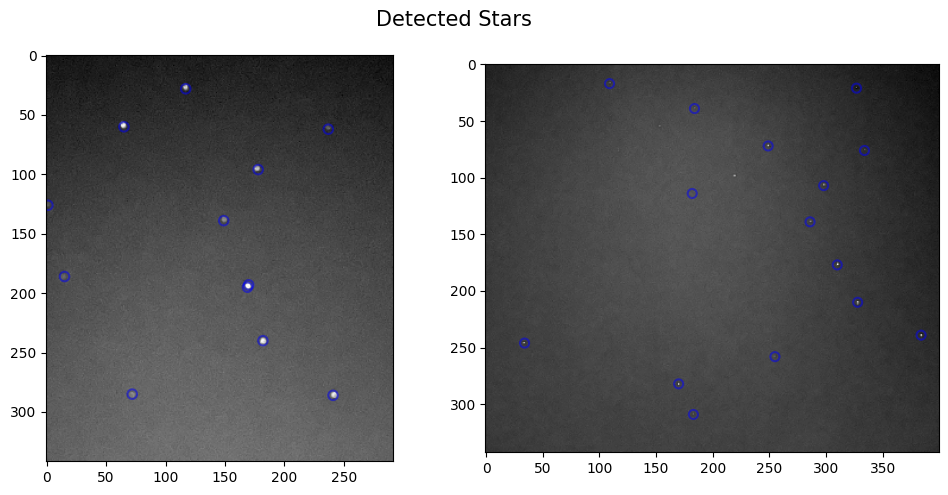

In [502]:
# plot detected stars in each image

im1_positions = np.transpose((im1_stars['xcentroid'], im1_stars['ycentroid']))
im1_apertures = CircularAperture(im1_positions, r=4.0)

im2_positions = np.transpose((im2_stars['xcentroid'], im2_stars['ycentroid']))
im2_apertures = CircularAperture(im2_positions, r=4.0)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Detected Stars", size=15)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')
im1_apertures.plot(ax=ax[0], color='blue', lw=1.5, alpha=0.5)
im2_apertures.plot(ax=ax[1], color='blue', lw=1.5, alpha=0.5)
plt.tight_layout()
plt.show()

## 3. Calculate Distances of Triangles in the Images

In [503]:
# all combinations of 3 points from each set
im1_combinations = list(combinations(range(len(im1_positions)), 3))
im2_combinations = list(combinations(range(len(im2_positions)), 3))

In [504]:
"""
Calculates Euclidean distance between two points.

Equivalent to:
x1, y1 = im1_positions[0]
x2, y2 = im1_positions[1]
math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
"""


def calc_dist(pos1, pos2):
    return math.dist(pos1, pos2)

In [505]:
def get_triangles(positions, combinations_lst) -> list[np.ndarray]:
    # loop combinations to compute distances
    triangles = []
    for i, comb in enumerate(combinations_lst):
        idx1, idx2, idx3 = comb
        pt1, pt2, pt3 = positions[idx1], positions[idx2], positions[idx3]
        distances = np.array([calc_dist(pt1, pt2), calc_dist(pt1, pt3), calc_dist(pt2, pt3)])
        min_side = distances.min()
        distances /= min_side  # normalize distances (THIS STEP IS IMPORTANT FOR TRIANGLE SIMILARITY!)
        # distances.sort()  # sorts ascending (low to high), inplace (returns void)
        triangles.append(distances)
    return triangles

In [506]:
im1_triangles = get_triangles(im1_positions, im1_combinations)
im2_triangles = get_triangles(im2_positions, im2_combinations)

In [507]:
def get_error(tri1: np.ndarray, tri2: np.ndarray, method: str = 'l2') -> float:
    """
    L1 or L2 error to check if 2 triangles are similar.
    :param tri1: normalized length of triangle-1 sides
    :param tri2: normalized length of triangle-2 sides
    :param method: l1 or l2
    :return: calculated error
    """
    tri1.sort()
    tri2.sort()
    diff = tri1 - tri2
    if method == 'l1':
        return sum(np.abs(diff))
    else:  # l2
        return math.sqrt(sum(np.power(diff, 2)))

In [508]:
sums = []
thresh = 1.
curr_best_match, curr_min_err = None, math.inf

for i, im1_tri in enumerate(im1_triangles):
    for j, im2_tri in enumerate(im2_triangles):
        curr_err = get_error(im1_tri.copy(),
                             im2_tri.copy())  # the sides of each triangle were normalized and can be compared
        if curr_err < curr_min_err:
            curr_best_match = [i, j, curr_err]  # [idx-image-1, idx-image-2, error]
            curr_min_err = curr_err
    if curr_min_err < thresh and curr_best_match is not None:
        sums.append(curr_best_match)
    curr_best_match, curr_min_err = None, math.inf

In [509]:
sums = sorted(sums, key=lambda item: item[2])  # sort from lowest to highest error
sums[:5]

[[99, 46, 0.0007850597212753939],
 [42, 349, 0.003011424427200122],
 [41, 404, 0.003443774797142916],
 [116, 17, 0.004249978715392698],
 [205, 262, 0.005150553082537724]]

## 4. Plot Matches

In [510]:
col_names = ['im1_comb_idx', 'im2_comb_idx', 'diff']
df = pd.DataFrame(data=sums, columns=col_names)
df[col_names[:2]] = df[col_names[:2]].astype(int)
print(f"Number of entries (before): {df.shape[0]}")
df.head()

Number of entries (before): 210


,im1_comb_idx,im2_comb_idx,diff
0,99,46,0.000785
1,42,349,0.003011
2,41,404,0.003444
3,116,17,0.004250
4,205,262,0.005151


In [511]:
"""
There are no duplicates in the first column since only one matching
triangle from the second image (with the lowest error) is taken.
df.drop_duplicates(subset=col_names[0], keep='first', inplace=True)
"""
df.drop_duplicates(subset=col_names[1], keep='first', inplace=True)
print(f"Number of entries (after): {df.shape[0]}")
df.head()

Number of entries (after): 147


,im1_comb_idx,im2_comb_idx,diff
0,99,46,0.000785
1,42,349,0.003011
2,41,404,0.003444
3,116,17,0.004250
4,205,262,0.005151


In [512]:
# take only best points!
reduced_sums = df.to_numpy().tolist()

In [513]:
def plot_single(n_columns, im1_pts, im2_pts):
    # get point apertures
    im1_aper = CircularAperture(im1_pts, r=4.0)
    im2_aper = CircularAperture(im2_pts, r=4.0)

    # remove grid for simpler display
    for k in range(n_columns):
        ax[row, k].get_xaxis().set_visible(False)
        ax[row, k].get_yaxis().set_visible(False)

    # plot triangle sides
    ax[0].add_patch(Polygon(im1_pts, fill=None, edgecolor='red', lw=1.5, alpha=0.5))
    ax[1].add_patch(Polygon(im2_pts, fill=None, edgecolor='red', lw=1.5, alpha=0.5))

    ax[0].imshow(im1, cmap='gray')
    im1_aper.plot(ax=ax[0], color='blue', lw=1.5, alpha=0.5)

    ax[1].imshow(im2, cmap='gray')
    im2_aper.plot(ax=ax[1], color='blue', lw=1.5, alpha=0.5)

In [514]:
def plot_multiple(n_columns, im1_pts, im2_pts):
    # get point apertures
    im1_aper = CircularAperture(im1_pts, r=4.0)
    im2_aper = CircularAperture(im2_pts, r=4.0)

    # remove grid for simpler display
    for k in range(n_columns):
        ax[row, k].get_xaxis().set_visible(False)
        ax[row, k].get_yaxis().set_visible(False)

    # plot triangle sides
    ax[row, 0].add_patch(Polygon(im1_pts, fill=None, edgecolor='red', lw=1.5, alpha=0.5))
    ax[row, 1].add_patch(Polygon(im2_pts, fill=None, edgecolor='red', lw=1.5, alpha=0.5))

    ax[row, 0].imshow(im1, cmap='gray')
    im1_aper.plot(ax=ax[row, 0], color='blue', lw=1.5, alpha=0.5)

    ax[row, 1].imshow(im2, cmap='gray')
    im2_aper.plot(ax=ax[row, 1], color='blue', lw=1.5, alpha=0.5)

In [515]:
def get_similar_triangle_coordinates(sums_lst, row_num):
    curr_tri = sums_lst[row_num]
    im1_idx, im2_idx, _ = curr_tri
    im1_idx, im2_idx = round(im1_idx), round(im2_idx)
    im1_comb, im2_comb = im1_combinations[im1_idx], im2_combinations[im2_idx]
    im1_matches, im2_matches = [], []
    for i, j in zip(im1_comb, im2_comb):  # get point coordinates
        im1_matches.append(im1_positions[i])
        im2_matches.append(im2_positions[j])
    return im1_matches, im2_matches

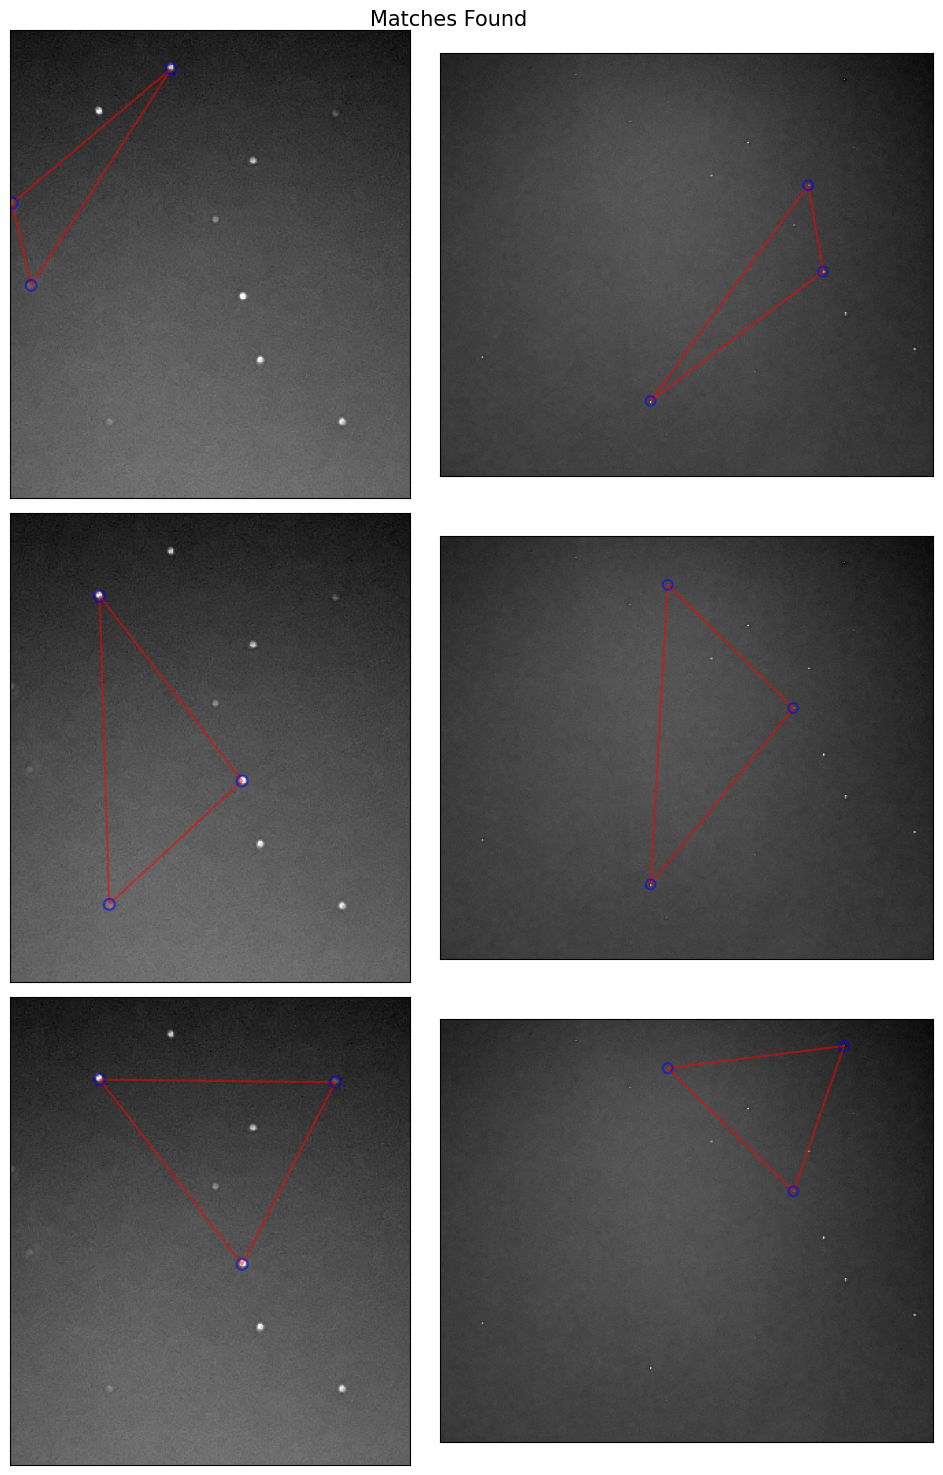

In [516]:
n_rows = 3
n_cols = 2
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 5 * n_rows))
fig.suptitle("Matches Found", size=15)

for row in range(n_rows):
    im1_match_pts, im2_match_pts = get_similar_triangle_coordinates(reduced_sums, row)

    if n_rows == 1:
        plot_single(n_cols, im1_match_pts, im2_match_pts)

    else:
        plot_multiple(n_cols, im1_match_pts, im2_match_pts)

plt.tight_layout()
plt.show()

## 5. Find exact matching points

In [517]:
# def get_point_pairs(sums_lst):
#     matches = []
#     for curr_tri in sums_lst:
#         im1_idx, im2_idx, _ = curr_tri
#         im1_comb, im2_comb = im1_combinations[im1_idx], im2_combinations[im2_idx]
#         im1_tri_dist, im2_tri_dist = im1_triangles[im1_idx].copy(), im2_triangles[im2_idx].copy()
#         im1_min_idx, im2_min_idx = np.argmin(im1_tri_dist), np.argmin(im1_tri_dist)
#
#
#
#
#         break

In [518]:
arr = []
for row in range(len(sums)):
    im1_match_pts, im2_match_pts = get_similar_triangle_coordinates(sums, row)
    # loop to get all combinations of points in triangle
    for pt1 in im1_match_pts:
        for pt2 in im2_match_pts:
            arr.append(np.array([pt1, pt2]))
arr = np.array(arr)

In [519]:
from skimage.transform import SimilarityTransform
from skimage.measure import ransac

In [520]:
model, inliers = ransac((arr[:, 0], arr[:, 1]), SimilarityTransform, min_samples=5, residual_threshold=0.2)
print(arr[inliers])
new_arr = arr[inliers]

[[[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]

 [[178  96]
  [182 114]]]


In [521]:
sum(inliers)

13

## 6. Save Stars as a Text File

In [522]:
def stars_to_text_file(stars_data, filename):
    relevant_data = np.transpose((stars_data['xcentroid'],
                                  stars_data['ycentroid'],
                                  stars_data['radius'],
                                  stars_data['brightness']))
    np.savetxt(filename, relevant_data, delimiter='\t', fmt='%f')

In [523]:
stars_to_text_file(im1_stars, "data/stars1.txt")
stars_to_text_file(im2_stars, "data/stars2.txt")

---------------

### Note:
How to reach indices:

```text
positions (x,y) <- combinations (index of 3 positions) <- index of combination and triangles are corresponding
```

## Useful Sources:
1. https://stackoverflow.com/questions/43126580/match-set-of-x-y-points-to-another-set-that-is-scaled-rotated-translated-and
2. https://photutils.readthedocs.io/en/stable/detection.html
3. https://www.mathopenref.com/similartrianglesparts.html
